In [1]:
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

In [4]:
api_key = os.getenv("OPENAI_API_KEY")
serper_api_key = os.getenv("SERPER_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")

In [5]:
tavily_key = os.getenv("tavily_key")

In [6]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="deepseek-r1-distill-llama-70b",api_key=groq_api_key)

In [7]:
llm.invoke("what is Data Science?").content

"<think>\nOkay, so I need to figure out what Data Science is. I've heard the term a lot, especially in tech circles, but I'm not entirely sure what it entails. Let me start by breaking it down. \n\nData Science... the name suggests it's a field related to data and science. I know that science involves systematic methods and analysis, so maybe Data Science is about systematically analyzing data. But how?\n\nI remember reading somewhere that Data Science involves extracting insights from data. That makes sense because data on its own is just numbers and information, but insights are what make it useful. So, Data Science must be the process of turning raw data into actionable information.\n\nI think it's a multidisciplinary field. I've heard it combines skills from statistics, computer science, and domain-specific knowledge. So, maybe a data scientist needs to know how to code, understand statistics, and have some expertise in the area they're applying their skills to, like healthcare or 

In [8]:
os.environ["TAVILY_API_KEY"] = tavily_key

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults
search = TavilySearchResults(max_results=5)

In [10]:
search.invoke("who won the IPL between RCB and CSK")

[{'title': 'RCB vs CSK highlights, IPL 2025: Royal Challengers Bengaluru ...',
  'url': 'https://www.livemint.com/sports/cricket-news/csk-vs-rcb-live-score-updates-ipl-2025-chennai-super-kings-vs-royal-challengers-bengaluru-latest-scorecard-virat-dhoni-11743160996307.html',
  'content': 'RCB vs CSK highlights, IPL 2025: Royal Challengers Bengaluru beat Chennai Super Kings by 50 runs in their Indian Premier League (IPL) 2025 match on Friday. Chasing a target of 197, CSK ended up at 146 for 8 in 20 overs, their first defeat to RCB at Chepauk since 2008. [...] A total of 33 matches were played between the two teams. Out of the 33, CSK enjoy a 21-11 head-to-head record while one game ended in no result. The last match between CSK and RCB was won by the latter in the previous edition. It was also the same match which helped RCB enter the playoffs.\n\nCSK vs RCB LIVE Score: Massive craze for Dhoni, Virat in Chennai [...] RCB vs CSK LIVE Score: RCB win by 50 runs\n\nTwo sixes and a four in th

In [11]:
## my web search and llm is working fine i can use both of them

In [12]:
## so what actually i am going to make 
## how actually this system will work
## what this system will take as input
## and what output this system will give

In [13]:
"""  This is multiagent supervisor system, on top we will have the supervisor agent under this supervisor agent
we will have another agents working for this supervisor agent.this supervisor agnet will have information about each agent
like how any particular agent will work internally what input it will take and what output it will provide.The user question will
be sent to this supervisor agent based on this supervisor agent will decide to which agent we will send this question.
after the question is sent to a particular agent. that agent will do its processing and will generate the output.this generated output will
be sent to supervisor and this supervisor will give that output to another agent as input and process will continue until the suoervisor agent 
finds that now we need to give the answer to user. so basically our system will work like this.
now we need to understand how this supervisor agnet technique is different from network agent technique, in the network agent technique which we have already done
earlier. there was no any superbisor agent.
"""

'  This is multiagent supervisor system, on top we will have the supervisor agent under this supervisor agent\nwe will have another agents working for this supervisor agent.this supervisor agnet will have information about each agent\nlike how any particular agent will work internally what input it will take and what output it will provide.The user question will\nbe sent to this supervisor agent based on this supervisor agent will decide to which agent we will send this question.\nafter the question is sent to a particular agent. that agent will do its processing and will generate the output.this generated output will\nbe sent to supervisor and this supervisor will give that output to another agent as input and process will continue until the suoervisor agent \nfinds that now we need to give the answer to user. so basically our system will work like this.\nnow we need to understand how this supervisor agnet technique is different from network agent technique, in the network agent techn

In [14]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)


repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [15]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState,START,END
from langgraph.types import Command

members = ["researcher","coder"] ## these are the two agents which will be working in my system
options = members + ["FINISH"] ## supervisor can assign work to any of above two agents or it can also stop the flow
## writing the prompt for the supervisor agent
system_prompt = ("""
You are a superviser agent tasked with managing conversation between  the following workers
{members}.Given the following user request responsd with the worker to act next.Each wroker will perform a task
and respond with their result and status. When finish respond with FINISH.
""")

In [16]:
## i will make a router class
## this router class will be attached with llm
## so that llm will give structured output only
class router(TypedDict):
    "worker to route next. if no worker needed move to FINISH"
    next: Literal["researcher","coder","FINISH"]


In [17]:
class State(MessagesState):
    next:str

In [18]:
## from now ownwards i will write the entire code on my own
def supervisor_node(state:State)-> Command[Literal["researcher","coder","__end__"]]: ## this function  can return these three things
    question = state["messages"]
    messages = [{"role":"system","content":system_prompt}] + question
    response = llm.with_structured_output(router).invoke(messages)
    ## this response will be either researcher,coder or FINISH
    goto = response["next"]
    if goto == "FINISH":
        goto = END
    return Command(
        update = {"next":goto},
        goto = goto
    )

In [19]:
## till here i have created the system for the supervisor agent
## based on the given question my supervisor can decide to which agent i should call or i should end the process
## now i will be creating the researcher system
from langchain_core.messages import HumanMessage,BaseMessage
from langgraph.prebuilt import create_react_agent
researcher_agent = create_react_agent(
    llm,
    tools = [search],
    prompt = "You do search from web,and return the result"
)

def researcher_node(state:MessagesState) -> Command[Literal["supervisor"]]:
    response = researcher_agent.invoke(state)
   
    return Command(
        update = {"messages":HumanMessage(
            content = response["messages"][-1].content,name = "researcher"
        )},
        goto = "supervisor"

    )


In [20]:
## till here i have created the system for researcher 
## now i will be creating the system for chart generator
chart_gen_agent = create_react_agent(
    llm,
    tools = [python_repl_tool],
    prompt="The python code will be provided to you based on that code you will make tha chart"
)
def code_node(state:State) -> Command[Literal["supervisor"]]:
    response = chart_gen_agent.invoke(state)
    return Command(
        update = {"messages":HumanMessage(
            content = response["messages"][-1].content,name = "coder"
        )},
        goto = "supervisor"
    )

In [21]:
from langgraph.graph import START,StateGraph,END,MessagesState

In [22]:
## i think i have made both of the agents now i can make my workflow
workflow = StateGraph(State)
workflow.add_node("supervisor",supervisor_node)
workflow.add_node("researcher",researcher_node)
workflow.add_node("coder",code_node)
workflow.add_edge(START,"supervisor")
graph = workflow.compile()

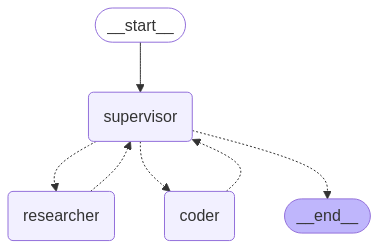

In [23]:
## we have designed the architecture of our graph now i will see how actually my graph is looking like
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [24]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': '__end__'}})
----


In [25]:
graph.invoke( {"messages": [("user", "What's the square root of 42?")]})["messages"][-1].content

"\n\nAlright, so I need to figure out the square root of 42. Hmm, I remember that the square root of a number is a value that, when multiplied by itself, gives the original number. So, for 42, I'm looking for a number that, when squared, equals 42.\n\nFirst, I'll try to estimate it. I know that 6 squared is 36 and 7 squared is 49. Since 42 is between 36 and 49, the square root of 42 must be between 6 and 7. To get a better estimate, I can see how far 42 is from 36 and 49. The difference between 36 and 42 is 6, and between 42 and 49 is 7. So, 42 is closer to 36 than to 49, which suggests that the square root is closer to 6 than to 7.\n\nTo get a more precise value, I'll use a method called the Newton-Raphson method for finding square roots. This method involves making an initial guess and then iteratively improving that guess until it's accurate enough.\n\nLet's start with an initial guess, x₀, of 6.5. The formula for the Newton-Raphson method is:\n\nx_{n+1} = (x_n + S/x_n) / 2\n\nwhere

In [27]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'supervisor': {'next': 'researcher'}}
----
{'researcher': {'messages': HumanMessage(content="I currently can't access real-time data or generate charts directly. However, I can guide you on how to obtain the UK's GDP data for the past five years and create a line chart.\n\n1. **Obtain GDP Data:**\n   - Visit a reliable source such as the [World Bank](https://www.worldbank.org/) or the [UK's Office for National Statistics](https://www.ons.gov.uk/).\n   - Navigate to the GDP section and download the historical data for the UK, covering the past five years.\n\n2. **Create a Line Chart:**\n   - Use spreadsheet software like Excel or Google Sheets.\n   - Import the GDP data into the software.\n   - Select the data range and use the chart creation tool to make a line chart.\n   - Customize the chart as needed (titles, axes labels, colors).\n\n3. **Alternative Tools:**\n   - **Python:** Use libraries like `matplotlib` or `seaborn` to create a line chart from the data.\n   - **R:** Use `ggplo